In [7]:
# Step 1: Import package,  Dataset uploading and preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(5)

pd.set_option('future.no_silent_downcasting', True)

data = pd.read_csv("./Resources/2024_ionosphere_data.csv", header=None)
data.iloc[:, 34] = data.iloc[:, 34].replace({'g': 1, 'b': 0})

# shuffling data
shuffled_data = data.sample(frac=1).astype(float)

# dividing data into training and test samples
train_data = shuffled_data.iloc[:int(0.8 * len(data))]
test_data = shuffled_data.iloc[int(0.8 * len(data)):]

pd.set_option('future.no_silent_downcasting', True)

# highlighting features and target variable
X_train = train_data.drop(train_data.columns[34], axis=1).values
y_train = train_data[train_data.columns[34]].values.reshape(-1,1)
X_test = test_data.drop(train_data.columns[34], axis=1).values
y_test = test_data[train_data.columns[34]].values.reshape(-1,1)

In [8]:
# Step 2: Define functions

# Xavier Initialization (Glorot Uniform)
def initialize_layer(input_dim, output_dim):
    weights = np.random.uniform(-1/np.sqrt(input_dim), 1/np.sqrt(input_dim), (input_dim, output_dim))
    biases = np.zeros((1, output_dim))
    return weights, biases

# Activation functions
def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1.0 - np.tanh(x)**2

def sigmoid(x):    
      return 1 / (1 + np.exp(-x))

def dsigmoid(x):
      return sigmoid(x) * (1 - sigmoid(x))

def binary_crossentropy_loss(p_pred, y_true):
    epsilon = 1e-15  # To avoid log(0)
    p_pred = np.clip(p_pred, epsilon, 1 - epsilon)  # Ensure probabilities are clipped between [epsilon, 1-epsilon]
    return -y_true * np.log(p_pred) - (1 - y_true) * np.log(1 - p_pred)


# def binary_crossentropy_loss(p_pred, y_true):
#     epsilon = 1e-15
#     return -y_true * np.log(p_pred + epsilon) - (1 - y_true) * np.log(1 - p_pred + epsilon)

def dbinary_crossentropy_loss(p_pred, y_true):
    return (-y_true / p_pred) + (1 - y_true) / (1 - p_pred)

def pca_reduce_to_2d(features):
    # Step 1: Center the data by subtracting the mean
    mean = np.mean(features, axis=0)
    centered_data = features - mean

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)  # Covariance matrix of the centered data

    # Step 3: Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: Sort eigenvectors by eigenvalues in descending order (top 2 eigenvectors)
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Get indices of the sorted eigenvalues
    top_2_eigenvectors = eigenvectors[:, sorted_indices[:2]]  # Select the top 2 eigenvectors

    # Step 5: Project the centered data onto the top 2 eigenvectors (PCA components)
    reduced_features = np.dot(centered_data, top_2_eigenvectors)

    return reduced_features

def train_model_not_apply_L2(
        X_train,
        y_train,
        X_test,
        y_test,
        input_dim,
        hidden_dim,
        output_dim,
        learning_rate,
        epochs,
        step,
        loss_show=True
):
    # Weights and bias for hidden and output layers
    W1, b1 = initialize_layer(input_dim, hidden_dim)
    W2, b2 = initialize_layer(hidden_dim, output_dim)

    train_losses = []
    test_losses = []
    latent_features = []

    for epoch in range(epochs):
        # forward propagation
        Z1 = np.dot(X_train, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2

        A2 = sigmoid(Z2)

        # backward propagation
        dA2 = dbinary_crossentropy_loss(A2, y_train)
        dZ2 = dsigmoid(Z2) * dA2
        dW2 = np.dot(A1.T, dZ2) / len(X_train)
        db2 = np.sum(dZ2, axis=0, keepdims=True) / len(X_train)

        # calc gradients to update weights and biases
        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * dtanh(Z1)
        dW1 = np.dot(X_train.T, dZ1) / len(X_train)
        db1 = np.sum(dZ1, axis=0, keepdims=True) / len(X_train)

        # update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        # compute loss (mean squared error for simplicity)
        train_loss = binary_crossentropy_loss(A2, y_train).mean()
        
        # saving losses
        train_losses.append(train_loss)
            
        # saving latent features at checkpoints
        if epoch % step == 0:
            latent_features.append(A1.copy())

        # forward propagation
        Z1 = np.dot(X_test, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)
        
        test_loss = binary_crossentropy_loss(A2, y_test).mean()
        test_losses.append(test_loss)
        
        if epoch % 1000 == 0 and loss_show:
            print(f"Epoch {epoch}/{epochs} - Loss of Train: {train_loss} & Test: {test_loss}")
        
        A2 = np.where(A2 < 0.5, 0, 1)

    return W1, b1, W2, b2, latent_features, train_losses, test_losses

def train_model_apply_L2(
        X_train,
        y_train,
        X_test,
        y_test,
        input_dim,
        hidden_dim,
        output_dim,
        learning_rate,
        epochs,
        step,
        lambda_val,
        loss_show=True
):
    # Weights and bias for hidden and output layers
    W1, b1 = initialize_layer(input_dim, hidden_dim)
    W2, b2 = initialize_layer(hidden_dim, output_dim)

    train_losses = []
    test_losses = []
    latent_features = []

    for epoch in range(epochs):
        # forward propagation
        Z1 = np.dot(X_train, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2

        A2 = sigmoid(Z2)

        # backward propagation
        dA2 = dbinary_crossentropy_loss(A2, y_train)
        dZ2 = dsigmoid(Z2) * dA2
        dW2 = np.dot(A1.T, dZ2) / len(X_train)
        db2 = np.sum(dZ2, axis=0, keepdims=True) / len(X_train)

        # calc gradients to update weights and biases
        dA1 = np.dot(dZ2, W2.T)
        dZ1 = dA1 * dtanh(Z1)
        dW1 = np.dot(X_train.T, dZ1) / len(X_train)
        db1 = np.sum(dZ1, axis=0, keepdims=True) / len(X_train)

        # update weights and biases
        W1 -= learning_rate * (dW1 + lambda_val * W1)
        b1 -= learning_rate * db1
        W2 -= learning_rate * (dW2 + lambda_val * W2)
        b2 -= learning_rate * db2

        # compute loss (mean squared error for simplicity)
        train_loss = binary_crossentropy_loss(A2, y_train).mean()
        
        # saving losses
        train_losses.append(train_loss)
            
        # saving latent features at checkpoints
        if epoch % step == 0:
            latent_features.append(A1.copy())

        # forward propagation
        Z1 = np.dot(X_test, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)
        
        test_loss = binary_crossentropy_loss(A2, y_test).mean()
        test_losses.append(test_loss)
        
        if epoch % 1000 == 0 and loss_show:
            print(f"Epoch {epoch}/{epochs} - Loss of Train: {train_loss} & Test: {test_loss}")
        
        A2 = np.where(A2 < 0.5, 0, 1)

    return W1, b1, W2, b2, latent_features, train_losses, test_losses

# Test function
def feedforward(W1,b1,W2,b2,X_test):
    # forward propagation
    Z1 = np.dot(X_test, W1) + b1
    A1 = tanh(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    # A2 = np.where(A2 < 0.5, 0, 1)
    return Z2, A2

def visualize_learning_curve(train_losses, test_losses):
    # Visualize the learning curves for both train and test data together
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title("Learning Curves - Train vs Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()  # Show legend to differentiate between train and test curves
    plt.grid(True)
    plt.show()

def visualize_2d_latent_space(ax, features, y, title):
    # Step 1: Reduce dimensions using custom PCA
    reduced_features = pca_reduce_to_2d(features)  # Reducing to 2 dimensions

    # Step 2: Plot the reduced features in the given axis
    ax.scatter(reduced_features[y.reshape(-1) == 0][:, 0], reduced_features[y.reshape(-1) == 0][:, 1], color='blue', label='Class 1')
    ax.scatter(reduced_features[y.reshape(-1) == 1][:, 0], reduced_features[y.reshape(-1) == 1][:, 1], color='red', label='Class 2')

    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()
    ax.grid(True)

def visualie_latent_features(latent_features, step, hidden_dim):
    # After training, reduce latent features to 2D for each epoch checkpoint and visualize
    num_plots = len(latent_features)
    
    # Create subplots in a single row
    fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))  # Adjust size as needed
    fig.tight_layout(pad=4.0)  # Add some padding between plots

    for i, latent in enumerate(latent_features):
        if latent is not None:
            # Visualize each set of latent features
            visualize_2d_latent_space(axs[i], latent, y_train, f"{i * step} EPOCHS - 2D VISUALIZATION - {hidden_dim} NEURONS")

    plt.show()

def plot_actual_vs_predicted(actual, predicted, title="Actual vs Predicted"):
    # visualize the predict model against actual values (test data)
    plt.figure(figsize=(12, 6))
    plt.plot(predicted, label="Predicted", linestyle='-', marker='o')
    plt.plot(actual, label="Actual", linestyle='-', marker='.')
    plt.title("Model Predictions vs Actual Values")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

def thresholds(data):
    data = np.where(data < 0.5, 0, 1)
    return data

def create_mini_batches(X, Y, batch_size):
    m = X.shape[0]
    mini_batches = []

    # Shuffle the data before splitting into batches
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation, :]
    Y_shuffled = Y[permutation]

    # Create mini-batches
    num_batches = m // batch_size
    for i in range(num_batches):
        X_batch = X_shuffled[i * batch_size:(i + 1) * batch_size, :]
        Y_batch = Y_shuffled[i * batch_size:(i + 1) * batch_size]
        mini_batches.append((X_batch, Y_batch))

    # Handle the last batch if there are remaining samples
    if m % batch_size != 0:
        X_batch = X_shuffled[num_batches * batch_size:, :]
        Y_batch = Y_shuffled[num_batches * batch_size:]
        mini_batches.append((X_batch, Y_batch))

    return mini_batches

def train_model_apply_L2_with_batching(
        X_train,
        y_train,
        X_test,
        y_test,
        input_dim,
        hidden_dim,
        output_dim,
        learning_rate,
        epochs,
        step,
        lambda_val,
        batch_size,  # New batch_size parameter
        loss_show=True
):
    # Weights and bias for hidden and output layers
    W1, b1 = initialize_layer(input_dim, hidden_dim)
    W2, b2 = initialize_layer(hidden_dim, output_dim)

    train_losses = []
    test_losses = []
    latent_features = []

    for epoch in range(epochs):
        # Create mini-batches
        mini_batches = create_mini_batches(X_train, y_train, batch_size)

        # Iterate over mini-batches
        for (X_batch, Y_batch) in mini_batches:
            # forward propagation
            Z1 = np.dot(X_batch, W1) + b1
            A1 = tanh(Z1)
            Z2 = np.dot(A1, W2) + b2
            A2 = sigmoid(Z2)

            # backward propagation
            dA2 = dbinary_crossentropy_loss(A2, Y_batch)
            dZ2 = dsigmoid(Z2) * dA2
            dW2 = np.dot(A1.T, dZ2) / len(X_batch)
            db2 = np.sum(dZ2, axis=0, keepdims=True) / len(X_batch)

            # calc gradients to update weights and biases
            dA1 = np.dot(dZ2, W2.T)
            dZ1 = dA1 * dtanh(Z1)
            dW1 = np.dot(X_batch.T, dZ1) / len(X_batch)
            db1 = np.sum(dZ1, axis=0, keepdims=True) / len(X_batch)

            # update weights and biases with L2 regularization
            W1 -= learning_rate * (dW1 + lambda_val * W1)
            b1 -= learning_rate * db1
            W2 -= learning_rate * (dW2 + lambda_val * W2)
            b2 -= learning_rate * db2

        # After processing all mini-batches, compute loss for this epoch
        Z1 = np.dot(X_train, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)
        train_loss = binary_crossentropy_loss(A2, y_train).mean()
        train_losses.append(train_loss)

        # saving latent features at checkpoints
        if epoch % step == 0:
            latent_features.append(A1.copy())

        # forward propagation on test data
        Z1 = np.dot(X_test, W1) + b1
        A1 = tanh(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = sigmoid(Z2)
        test_loss = binary_crossentropy_loss(A2, y_test).mean()
        test_losses.append(test_loss)

        if epoch % 1000 == 0 and loss_show:
            print(f"Epoch {epoch}/{epochs} - Loss of Train: {train_loss} & Test: {test_loss}")
        
        A2 = np.where(A2 < 0.5, 0, 1)

    return W1, b1, W2, b2, latent_features, train_losses, test_losses

Epoch 0/10001 - Loss of Train: 0.6763807048903826 & Test: 0.6678373837579957
Epoch 1000/10001 - Loss of Train: 0.22340289423748064 & Test: 0.2419381053214526
Epoch 2000/10001 - Loss of Train: 0.15334563323433323 & Test: 0.21365317546601556
Epoch 3000/10001 - Loss of Train: 0.10515531158770293 & Test: 0.22498072345209152
Epoch 4000/10001 - Loss of Train: 0.07745725622820758 & Test: 0.24172837934966582
Epoch 5000/10001 - Loss of Train: 0.05941463537643273 & Test: 0.26752661021408386
Epoch 6000/10001 - Loss of Train: 0.04694014030672532 & Test: 0.2946345662046159
Epoch 7000/10001 - Loss of Train: 0.037006789278224615 & Test: 0.3226725115033572
Epoch 8000/10001 - Loss of Train: 0.029677430552104513 & Test: 0.34752056264409875
Epoch 9000/10001 - Loss of Train: 0.024571973092368294 & Test: 0.36780515434146155
Epoch 10000/10001 - Loss of Train: 0.020788221167689285 & Test: 0.385126518897679


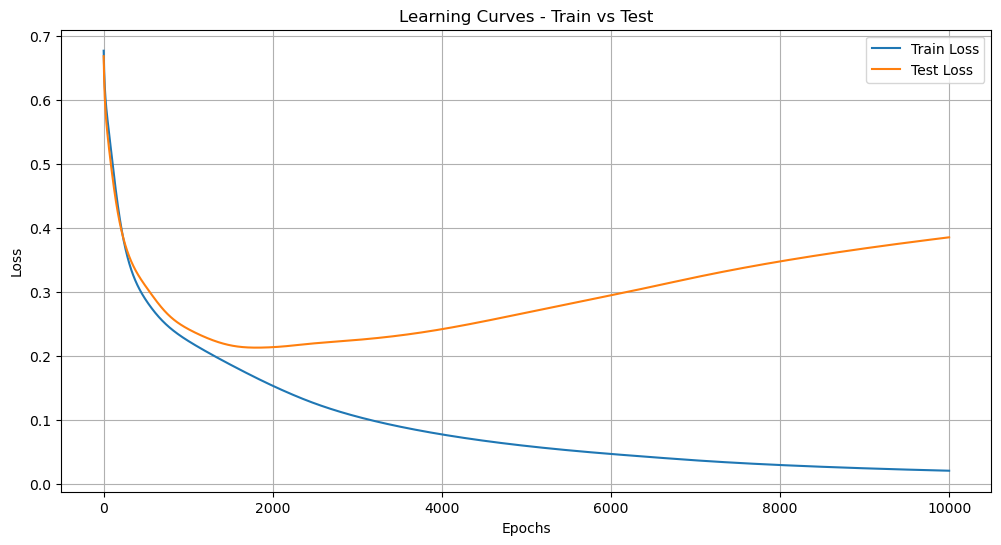

BCE loss for Train Data: 0.020784937090155928
BCE loss for Test Data: 0.385126518897679


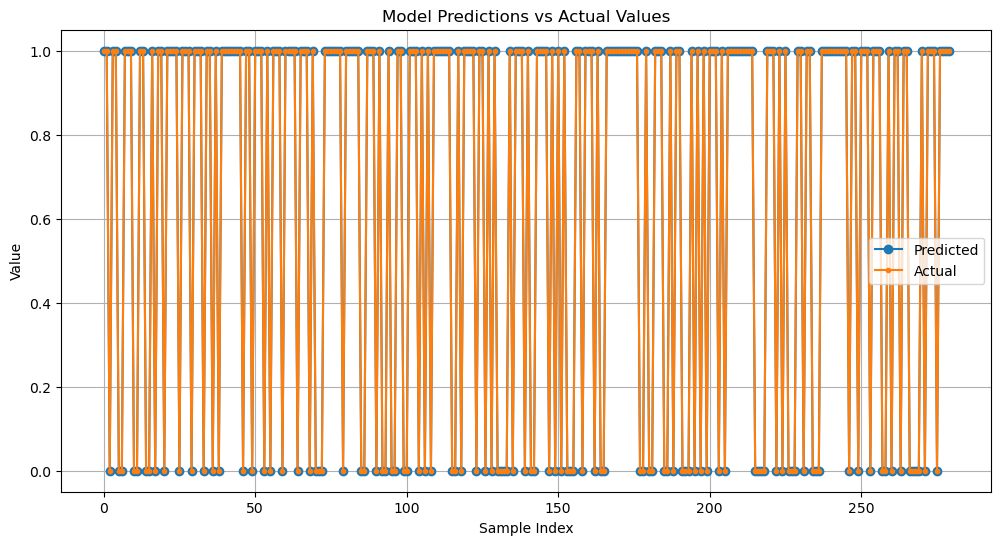

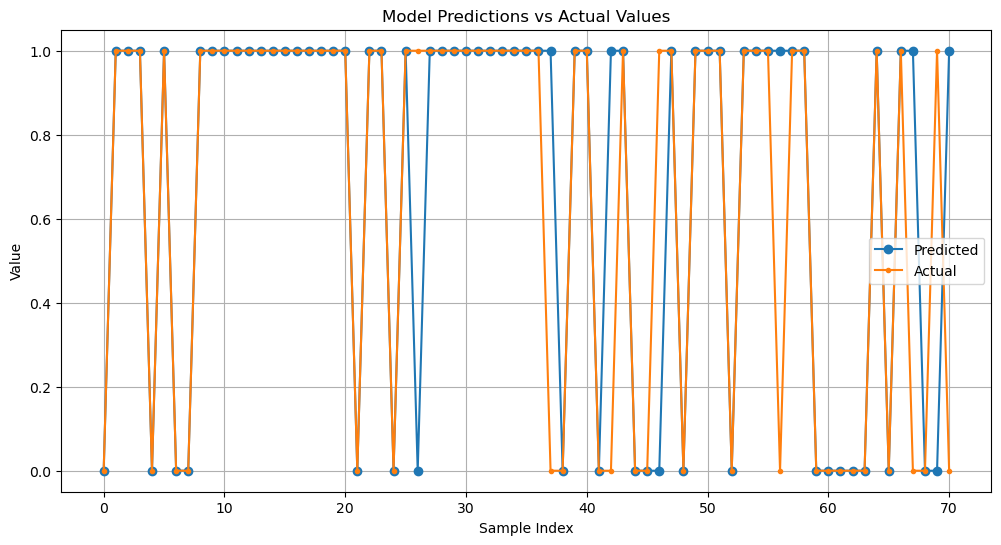

In [3]:
# Step 3.1: Training our model - Do not apply L2

# Input layer - 34
input_dim = X_train.shape[1]
# hidden layer - 3
hidden_dim = 3
# output layer - 1
output_dim = y_train.shape[1]

learning_rate = 0.05 
epochs = 10001
step = 5000

W1, b1, W2, b2, latent_features, train_losses, test_losses = train_model_not_apply_L2(
    X_train,
    y_train,
    X_test,
    y_test,
    input_dim,
    hidden_dim,
    output_dim,
    learning_rate,
    epochs,
    step
)

visualize_learning_curve(
    train_losses,
    test_losses
)

_, Y_pred_train = feedforward(W1,b1,W2,b2,X_train)
_, Y_pred_test = feedforward(W1,b1,W2,b2,X_test)

bce_train = binary_crossentropy_loss(Y_pred_train, y_train).mean()
bce_test = binary_crossentropy_loss(Y_pred_test, y_test).mean()
print(f"BCE loss for Train Data: {bce_train}")
print(f"BCE loss for Test Data: {bce_test}")

plot_actual_vs_predicted(y_train, thresholds(Y_pred_train))
plot_actual_vs_predicted(y_test, thresholds(Y_pred_test))

Epoch 0/10001 - Loss of Train: 0.6936325007559299 & Test: 0.6694725068849623
Epoch 1000/10001 - Loss of Train: 0.334212784487698 & Test: 0.34834572088896637
Epoch 2000/10001 - Loss of Train: 0.3286327408328779 & Test: 0.33746255650597345
Epoch 3000/10001 - Loss of Train: 0.327481796721 & Test: 0.33355384308045405
Epoch 4000/10001 - Loss of Train: 0.32670020948114686 & Test: 0.33139640082291427
Epoch 5000/10001 - Loss of Train: 0.3259671764924408 & Test: 0.32994563144167877
Epoch 6000/10001 - Loss of Train: 0.32535643250770657 & Test: 0.3289738105403448
Epoch 7000/10001 - Loss of Train: 0.3249384012423062 & Test: 0.32839828778850216
Epoch 8000/10001 - Loss of Train: 0.32468562117766187 & Test: 0.32809318386980074
Epoch 9000/10001 - Loss of Train: 0.3245424813639947 & Test: 0.3279444731511425
Epoch 10000/10001 - Loss of Train: 0.32446469181012544 & Test: 0.3278784283542565


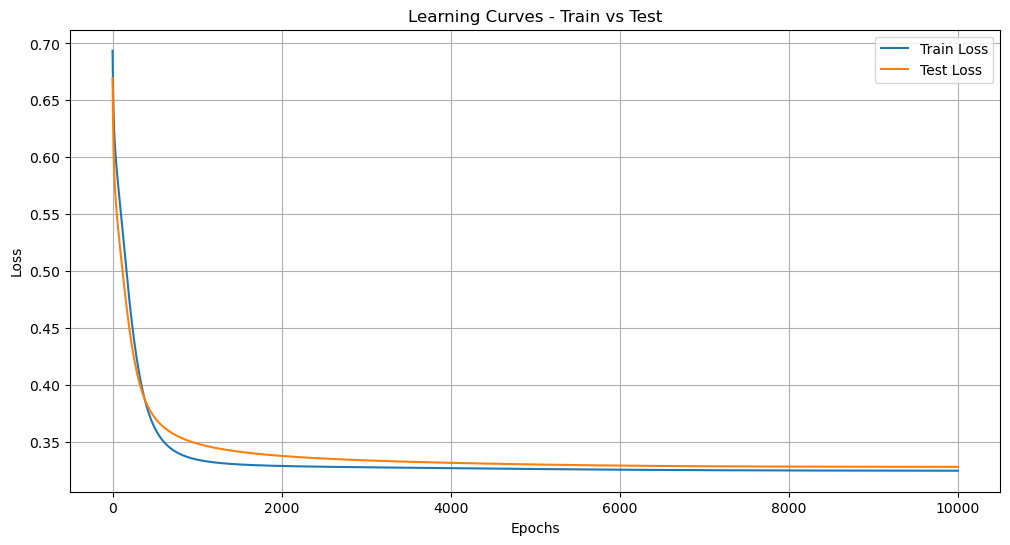

BCE loss for Train Data: 0.3244646361259648
BCE loss for Test Data: 0.3278784283542565


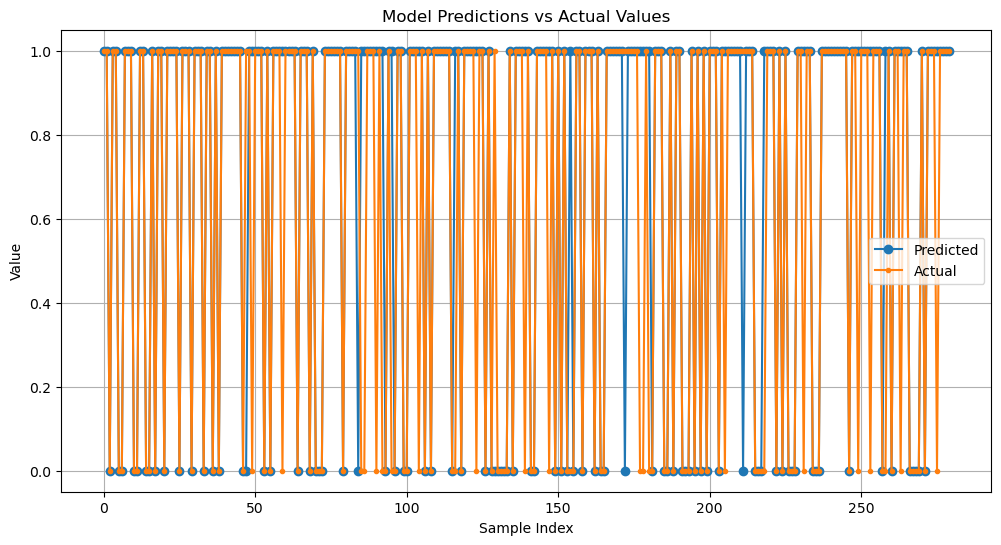

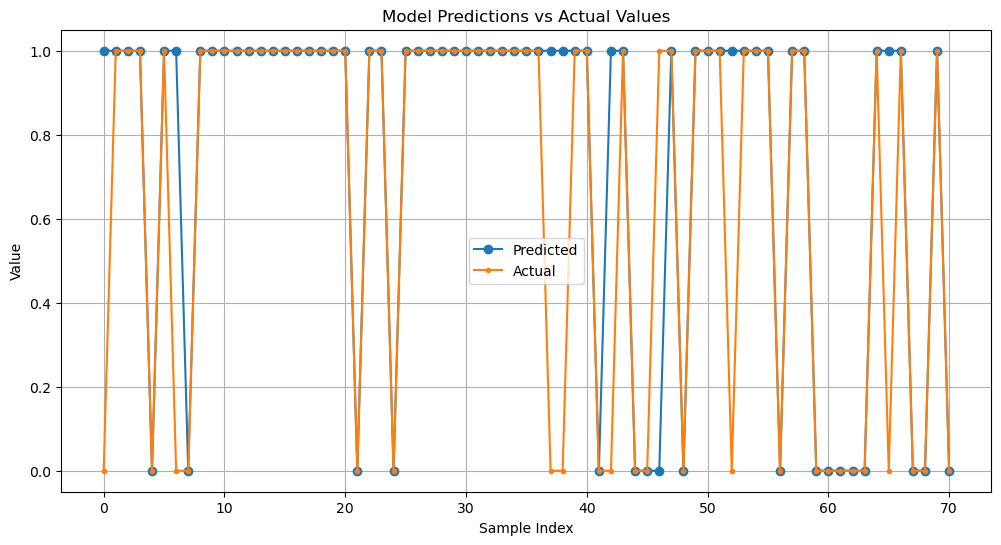

In [4]:
# Step 3.2: Training our model - Apply L2 
# --> Choose this model to compare the different number of neuron in the hidden layers which places in front of output layer

# Input layer - 34
input_dim = X_train.shape[1]
# hidden layer - 3
hidden_dim = 3
# output layer - 1
output_dim = y_train.shape[1]

learning_rate = 0.05 
epochs = 10001
step = 5000
lambda_val = 0.045

W1, b1, W2, b2, latent_features, train_losses, test_losses = train_model_apply_L2(
    X_train,
    y_train,
    X_test,
    y_test,
    input_dim,
    hidden_dim,
    output_dim,
    learning_rate,
    epochs,
    step,
    lambda_val
)

visualize_learning_curve(
    train_losses,
    test_losses
)

_, Y_pred_train = feedforward(W1,b1,W2,b2,X_train)
_, Y_pred_test = feedforward(W1,b1,W2,b2,X_test)


bce_train = binary_crossentropy_loss(Y_pred_train, y_train).mean()
bce_test = binary_crossentropy_loss(Y_pred_test, y_test).mean()
print(f"BCE loss for Train Data: {bce_train}")
print(f"BCE loss for Test Data: {bce_test}")

plot_actual_vs_predicted(y_train, thresholds(Y_pred_train))
plot_actual_vs_predicted(y_test, thresholds(Y_pred_test))

Epoch 0/10001 - Loss of Train: 0.6629991345232179 & Test: 0.6498625086234295
Epoch 1000/10001 - Loss of Train: 0.3235702392069424 & Test: 0.32863714617567563
Epoch 2000/10001 - Loss of Train: 0.3229029712870683 & Test: 0.32635484981526774
Epoch 3000/10001 - Loss of Train: 0.3228062497497416 & Test: 0.32610154620235093
Epoch 4000/10001 - Loss of Train: 0.32583545801863417 & Test: 0.3277303754662038
Epoch 5000/10001 - Loss of Train: 0.32486600125217474 & Test: 0.3275040500242268
Epoch 6000/10001 - Loss of Train: 0.32506769388103324 & Test: 0.33122952040288434
Epoch 7000/10001 - Loss of Train: 0.3248472662200649 & Test: 0.3264850283336299
Epoch 8000/10001 - Loss of Train: 0.32573550712451466 & Test: 0.3304503124612579
Epoch 9000/10001 - Loss of Train: 0.3260785902289491 & Test: 0.32557297930250456
Epoch 10000/10001 - Loss of Train: 0.32449204858972086 & Test: 0.33037823741511424


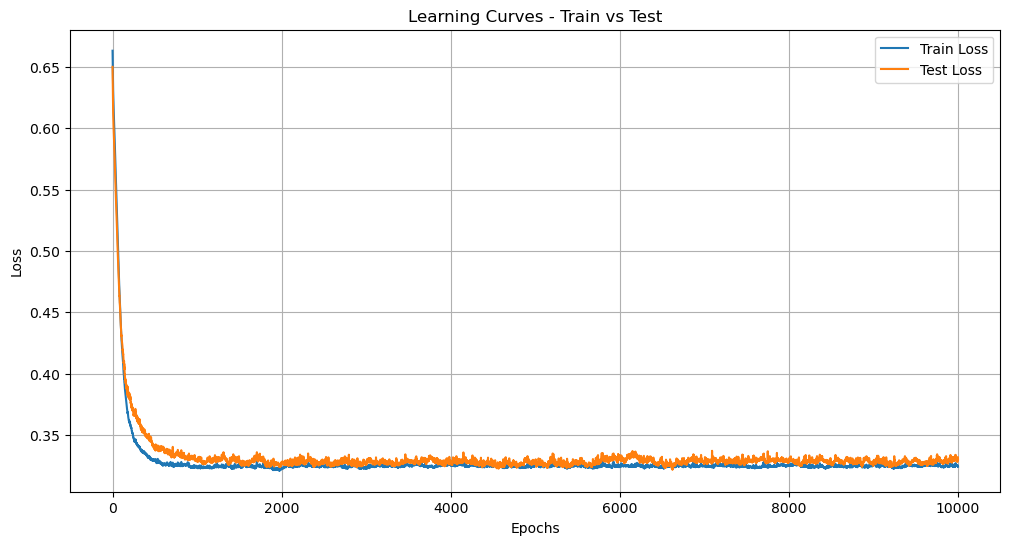

BCE loss for Train Data: 0.32449204858972086
BCE loss for Test Data: 0.33037823741511424


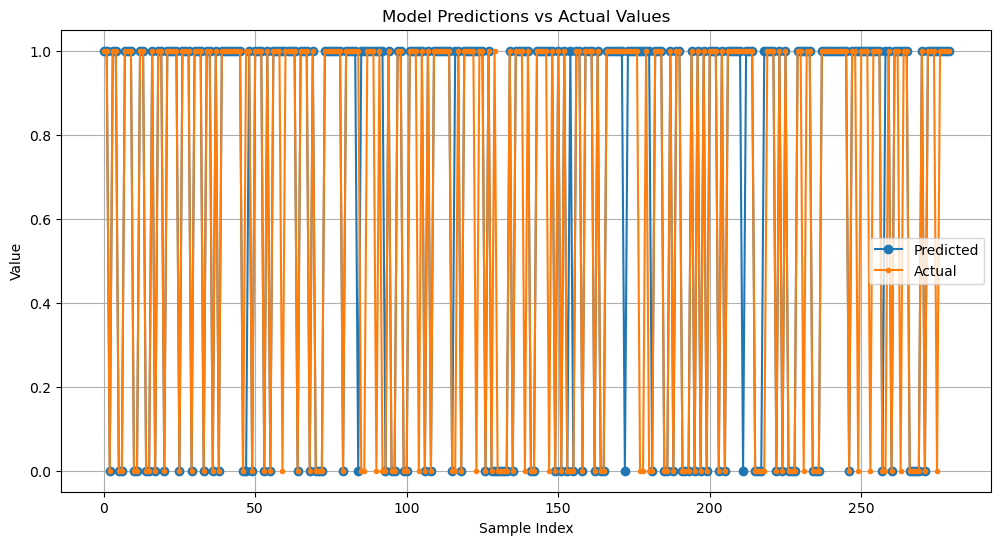

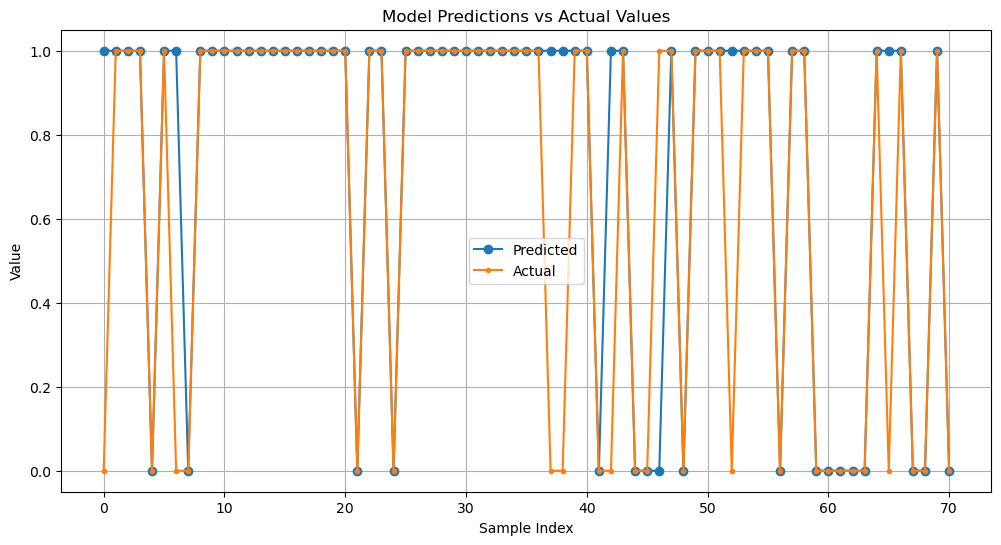

In [17]:
# Step 3.3: Training our model - Apply L2 + Batching 
# --> Choose this model to compare the different number of neuron in the hidden layers which places in front of output layer

# Input layer - 34
input_dim = X_train.shape[1]
# hidden layer - 3
hidden_dim = 3
# output layer - 1
output_dim = y_train.shape[1]

learning_rate = 0.05 
epochs = 10001
step = 5000
lambda_val = 0.045

W1, b1, W2, b2, latent_features, train_losses, test_losses = train_model_apply_L2_with_batching(
    X_train,
    y_train,
    X_test,
    y_test,
    input_dim,
    hidden_dim,
    output_dim,
    learning_rate,
    epochs,
    step,
    lambda_val,
    batch_size=128
)

visualize_learning_curve(
    train_losses,
    test_losses
)

_, Y_pred_train = feedforward(W1,b1,W2,b2,X_train)
_, Y_pred_test = feedforward(W1,b1,W2,b2,X_test)


bce_train = binary_crossentropy_loss(Y_pred_train, y_train).mean()
bce_test = binary_crossentropy_loss(Y_pred_test, y_test).mean()
print(f"BCE loss for Train Data: {bce_train}")
print(f"BCE loss for Test Data: {bce_test}")

plot_actual_vs_predicted(y_train, thresholds(Y_pred_train))
plot_actual_vs_predicted(y_test, thresholds(Y_pred_test))

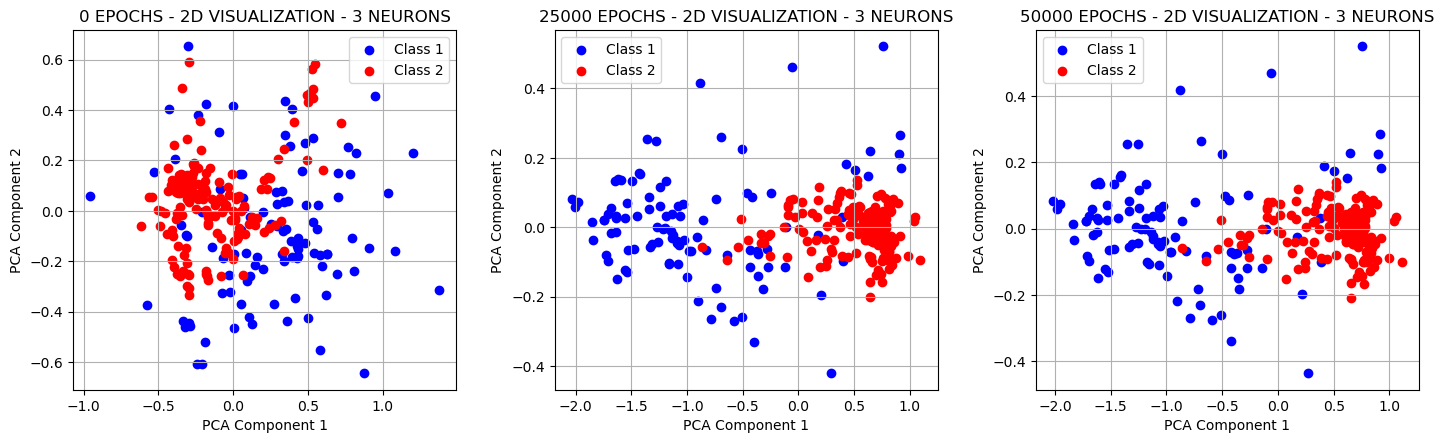

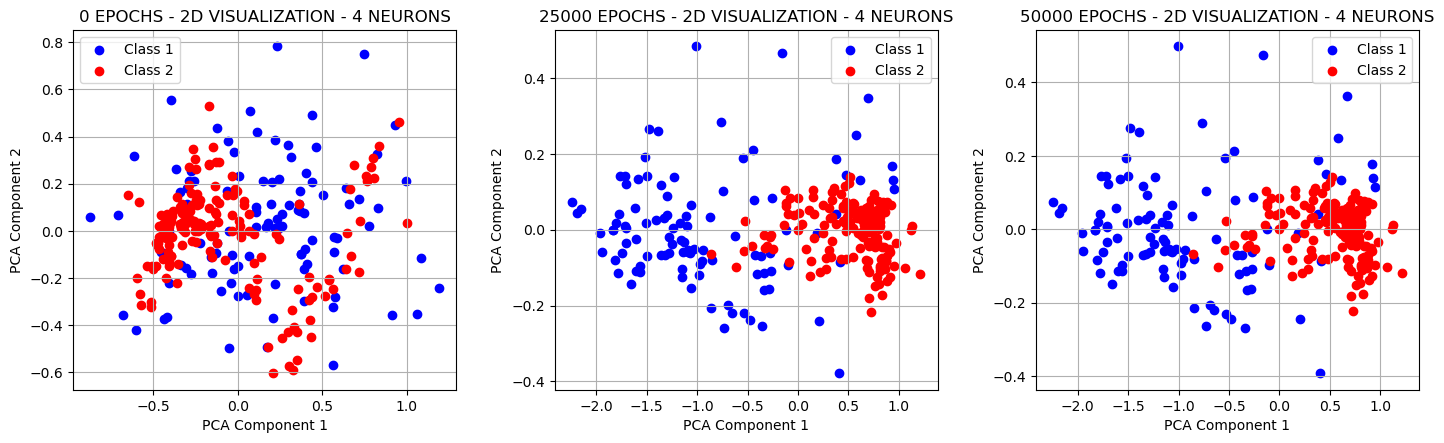

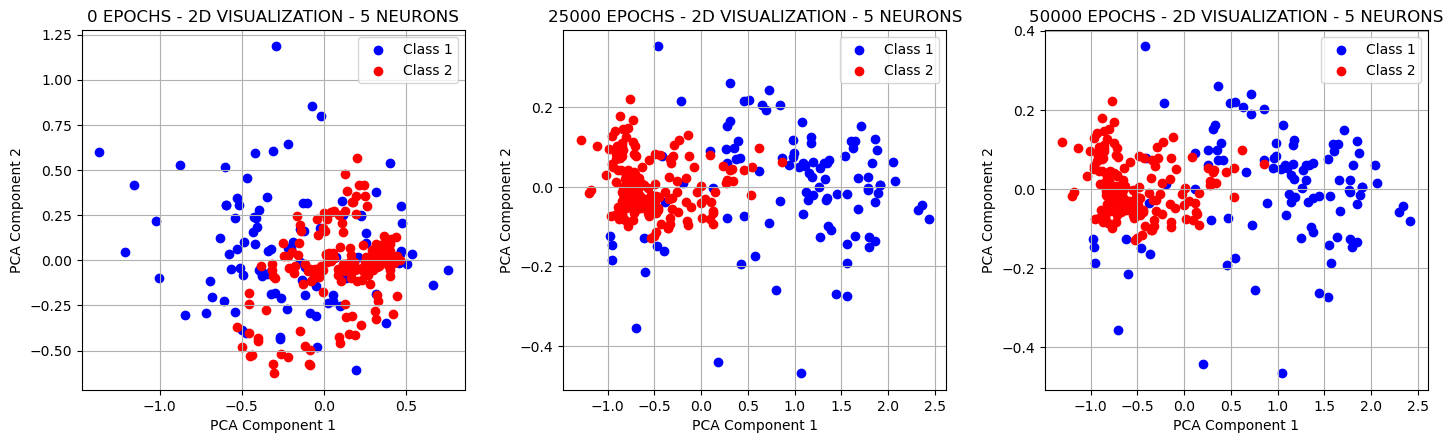

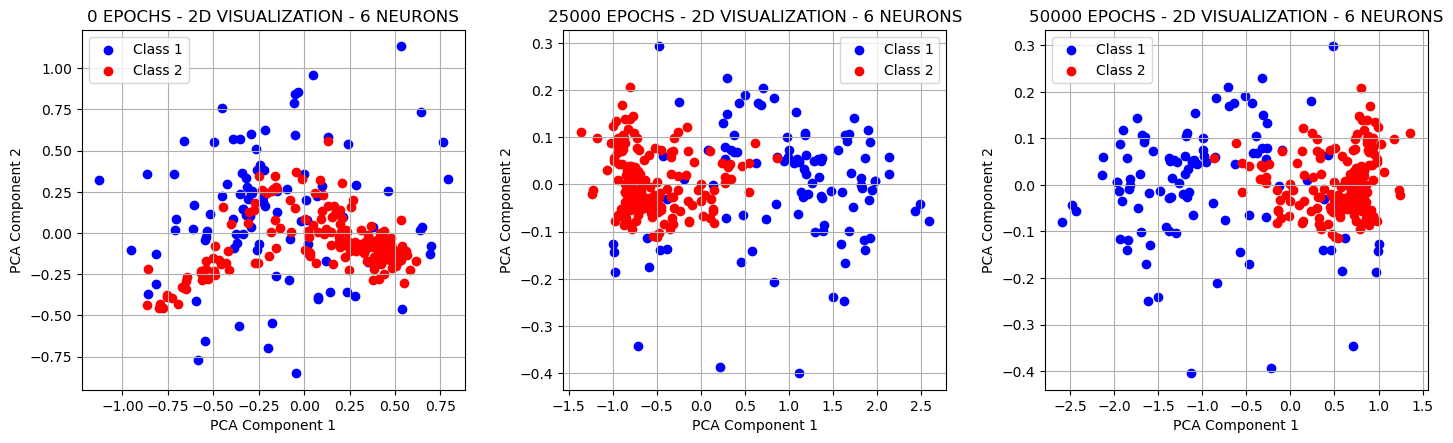

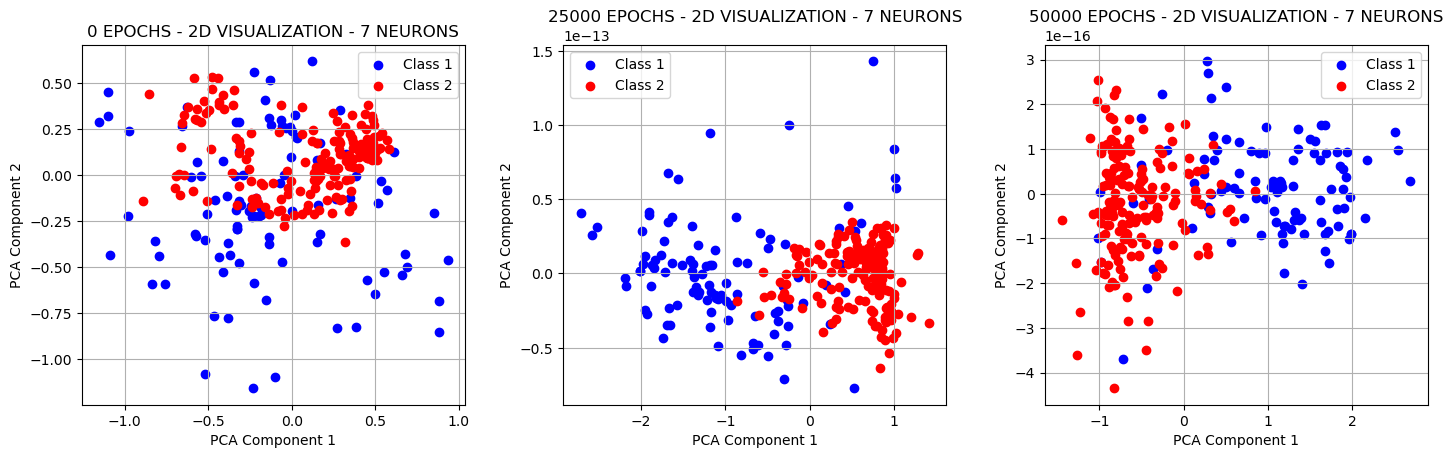

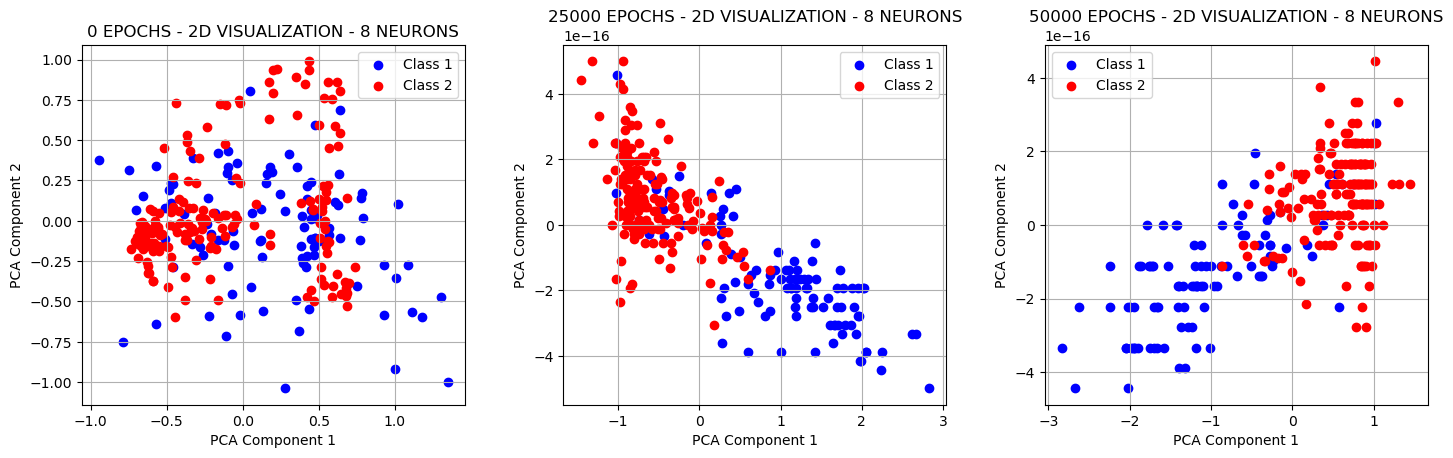

In [14]:
# Step 4: Visualize the latent features - Changing the number of neurons
# Input layer - 34
input_dim = X_train.shape[1]
# output layer - 1
output_dim = y_train.shape[1]
learning_rate = 0.05 
epochs = 50001
step = int(epochs/2)
lambda_val = 0.045
# Choose the range from 3 to 8
for i in range(3, 9):
    hidden_dim = i

    W1, b1, W2, b2, latent_features, train_losses, test_losses = train_model_apply_L2_with_batching(
        X_train,
        y_train,
        X_test,
        y_test,
        input_dim,
        hidden_dim,
        output_dim,
        learning_rate,
        epochs,
        step,
        lambda_val,
        32,
        False
    )

    visualie_latent_features(latent_features, step, hidden_dim)